# Drug Toxicity Prediction

왜 하는거지?
실험도 비싸고 연구도 비싸게 해서 신약을 개발했는데 Drug Toxicity가 너무 높아서 사용하지 못하면 말짱 꽝
이미 실험된 데이터를 패턴(머신러닝)을 통해서 미리 알 수 있다면 좋을 것.

In [1]:
!nvidia-smi
# Colab Free 사용제한으로 gpu 사용 불가

/bin/bash: line 1: nvidia-smi: command not found


# 필요한 라이브러리 및 데이터 준비

## 라이브러리 설치

In [3]:
!pip install PyTDC        # TDC = Therapeutics Data Commons, 바이오메디컬 벤치마킹 데이터 셋을 위한 연구
!pip install lifelines    # 생존 분석에 사용되는 metrics
!pip install rdkit-pypi   # 화합물 처리를 위한 라이브러리

  Using cached PyTDC-1.0.0.tar.gz (141 kB)
  Preparing metadata (setup.py) ... done
  Using cached biopython-1.84-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.2 MB)
  Using cached dataclasses-0.6-py3-none-any.whl (14 kB)
  Using cached fuzzywuzzy-0.18.0-py2.py3-none-any.whl (18 kB)
  Using cached mygene-3.2.2-py2.py3-none-any.whl (5.4 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.1/43.1 MB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.9/34.9 MB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 41.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.7/254.7 kB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 17.4 MB/s eta 0:

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.2/94.2 kB 6.7 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=1e6de66b8479b7df6bdac68b198eaae7160d1fbc08f3ee952ec03025a1a381f4
  Stored in directory: /root/.cache/pip/wheels/25/cc/e0/ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully built autograd-gamma
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 27.6 MB/s eta 0:00:00


## Toxicity Prediction Task Overview

**Definition** : 사람의 유기체에서 약품이 얼마나 독성을 가질지를 알아보아야 한다. 따라서, 학습 목표는 정확하게 다양한 종류의 의약물의 독성을 측정할 수 있는지이다.

**Impact** : 독성은 화합물 분해가 주요 원인 중 하나이다. 연구에 따르면 대략 70%의 독성 관련 생분해가 전임상 단계에서 발생하고 모두 인간에게 독성을 끼친다고 강하게 예측하는 것으로 나타났다. 이는 독성에 대한 초기의 정확한 예측이 화합물 독성을 크게 줄이고 시판 가능성을 높일 수 있음을 시사한다.

**Generalization** : ADME 예측과 유사하게, 관심있는 약의 화학구조가 시간이 지날수록 변화하기 때문에 독성 예측은 모델이 기존 약물 셋과 구조적 유사성이 적은 새로운 약물 셋으로 점차 일반화하는 동작이 필요하다.

**Product** : 저분자 화합물

**Pipeline** : 효율적이고 안전하게

### Acute Toxicity LD50

**Dataset Description** : Acute Toxicity LD50은 치명적인 부작용을 초래할 수 있는 약물의 가장 안전한 용량을 측정한다. 복용량이 높을수록 약물의 치사율이 높아진다.

**Task Descriptoin** : 회귀 방식을 활용한다. 약물의 SMILES 문자열을 통해 급성 독성을 예측할 것이다.


**Dataset Statistics** : 7,385 drugs

~추가로 포트폴리오를 만들 때, 다른 데이터에도 적용해볼 것.~



In [4]:
from tdc.single_pred import Tox

# TDC api를 이용하여 LD50 데이터 불러오기
data = Tox(name = 'LD50_Zhu')
# 불러온 데이터 train-valid-test로 나누기
split = data.get_split()

Downloading...
100%|██████████| 707k/707k [00:00<00:00, 1.88MiB/s]
Loading...
Done!





---


https://github.com/mims-harvard/TDC <br/>
https://tdcommons.ai/functions/data_split/

TDC github이나 TDC 공식 docs에 가면 split 하는 기준도 변경할 수 있다. 참고하자.

In [5]:
# split 확인하기
# split
split.keys()

dict_keys(['train', 'valid', 'test'])

In [6]:
# Train data 확인하기
split['train']

,Drug_ID,Drug,Y
0,"Methane, tribromo-",BrC(Br)Br,2.343
1,Bromoethene (9CI),C=CBr,2.330
2,"1,1'-Biphenyl, hexabromo-",Brc1ccc(-c2ccc(Br)c(Br)c2Br)c(Br)c1Br,1.465
3,"Isothiocyanic acid, p-bromophenyl ester",S=C=Nc1ccc(Br)cc1,2.729
4,"Benzene, bromo-",Brc1ccccc1,1.765
...,...,...,...
5165,"Benzenesulfonic acid, 3,5-dimethyl-4-hydroxy-",Cc1cc(S(=O)(=O)O)cc(C)c1O,1.883
5166,"Isocyanic acid, (alpha,alpha,alpha-trifluoro-o...",O=C=Nc1ccccc1C(F)(F)F,1.427
5167,"Propanenitrile, 3-((2-(acetyloxy)ethyl)phenyla...",CC(=O)OCCN(CCC#N)c1ccccc1,2.050
5168,"IH-Indene-1,3(2H)-dione, 2-(2-methyl-1-(2-(1-p...",CC1=CC(=C2C(=O)c3ccccc3C2=O)C=CN1CCN1CCCCC1,2.951


train = 5170개의 rows

In [7]:
split['valid']

,Drug_ID,Drug,Y
0,"Heptanoic acid, 7-iodo-",O=C(O)CCCCCCI,2.058
1,"2(1H)-Quinazolinone, 4-(3-hydroxyphenyl)-7-met...",Cc1ccc2c(-c3cccc(O)c3)nc(=O)n(C(C)C)c2c1,2.266
2,"Heptanoic acid, 2-(4-(3-(2-(trifluoromethyl)-1...",CCCCCCC(=O)OCCN1CCN(CCCN2c3ccccc3Sc3ccc(C(F)(F...,3.378
3,"1-Butanol, 2-ethyl-",CCC(CC)CO,1.742
4,"2,8,9-Trioxa-5-aza-1-silabicyclo(3.3.3)undecan...",Clc1cccc([Si]23OCCN(CCO2)CCO3)c1,4.255
...,...,...,...
733,"(1)-alpha,alpha,4-Trimethylcyclohex-3-ene-1-me...",CC1=CCC(C(C)(C)O)CC1,1.475
734,5-(Aminomethyl)isoxazol-3-ol hydrate,NCc1cc(=O)[nH]o1,3.404
735,"Acetaldehyde, diethyl acetal",CCOC(C)OCC,1.410
736,"3H-1,4-Benzodiazepin-2-amine, 7-chloro-N-(cycl...",[O-][N+]1=C(c2ccccc2)c2cc(Cl)ccc2N=C(NCC2CC2)C1,1.888


valid = 738개의 rows

In [8]:
split['test']

,Drug_ID,Drug,Y
0,"Ether, alpha-(bromomethyl)-p-cyclopentylbenzyl...",CCCCOC(CBr)c1ccc(C2CCCC2)cc1,3.114
1,"Benzene, 1,4-dinitroso-",O=Nc1ccc(N=O)cc1,2.125
2,"Succinic acid, mercapto-, diethyl ester, S-est...",CCOC(=O)CC(SP(=O)(OC)SC)C(=O)OCC,3.466
3,"Phosphorodithioic acid, O,S,S-triethyl ester",CCOP(=O)(SCC)SCC,3.185
4,"Phenol, 2-octyl- (9CI)",CCCCCCCCc1ccccc1O,1.867
...,...,...,...
1472,"1H-1,2,4-Triazole, 1-((2-(2,4-dichlorophenyl)-...",CCCC1COC(Cn2cncn2)(c2ccc(Cl)cc2Cl)O1,2.353
1473,"Phosphorothioic acid, O-(3-chloro-4-nitropheny...",CCOP(=S)(OCC)Oc1ccc([N+](=O)[O-])c(Cl)c1,3.814
1474,"Dibenz(b,f)oxepin-2-acetic acid, 10,11-dihydro...",Cc1ccc2c(c1)CC(=O)c1cc(CC(=O)O)ccc1O2,2.937
1475,"Phosphorothioic acid, O,O-dimethyl S-(2-(ethyl...",CCS(=O)(=O)CCSP(=O)(OC)OC,3.908


test = 1477개의 rows

조금 더 데이터들을 시각화해서 살펴보자.

<Axes: ylabel='Frequency'>

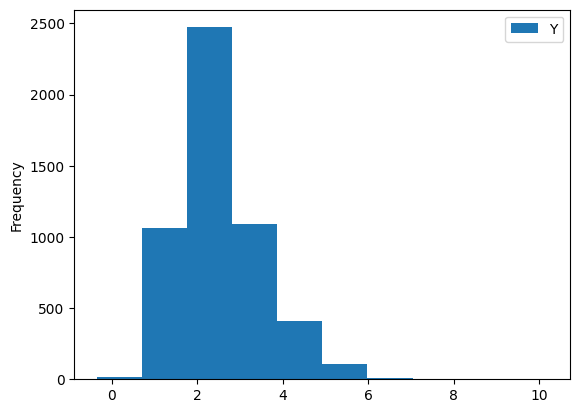

In [9]:
split["train"].plot.hist()

<Axes: ylabel='Frequency'>

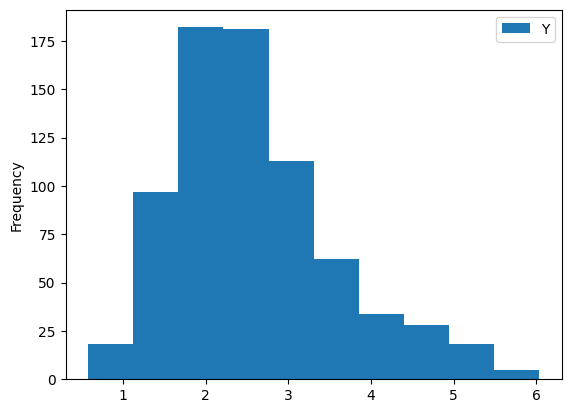

In [10]:
split["valid"].plot.hist()

<Axes: ylabel='Frequency'>

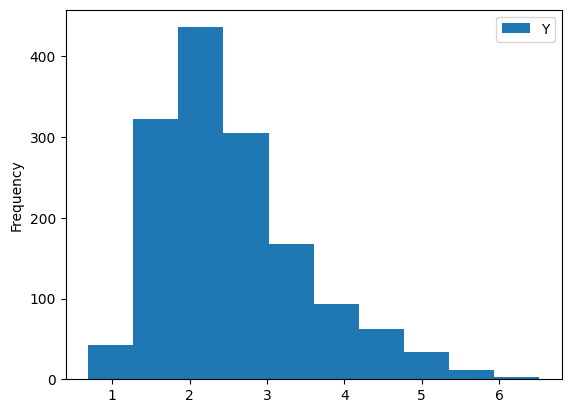

In [11]:
split['test'].plot.hist()

데이터들을 살펴봤을 때, 평균적으로 **2 언저리 값**을 가진다. 데이터를 이산적으로 바꾸기 위해서 이 성질을 활용해보자.

# 데이터 전처리(Data pre-processing)


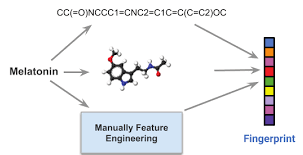

화합물의 이름이나 화학 공식을 그대로 활용하기는 어렵다. 따라서 화합물 데이터에 대해서 RDkit의 룰베이스 방식을 활용하여 벡터화해줄 것이다.


**자세한 내용은 아래 링크 참조하세요**

[RDkit](https://www.rdkit.org/docs/GettingStartedInPython.html)

[Molecular representations in AI-driven drug discovery: a review and practical guide](https://jcheminf.biomedcentral.com/articles/10.1186/s13321-020-00460-5)


[Extended-Connectivity Fingerprints](https://pubs.acs.org/doi/full/10.1021/ci100050tcasa_token=vsI6rp6l2RYAAAAA%3A_HTqMGypPZSQJnF4VqM4xl7KApBKMtKD1STnbh_EHOWeFOsfPKGETjY-SaiC-9XQtyhIEZHvGRRcMcEM)


In [12]:
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
import numpy as np

def smiles2morgan(s, radius = 2, nBits = 1024):
    """SMILES data를 morgan fingerprint 데이터로 변환

    Args:
        s (str): SMILES of a drug
        radius (int): ECFP radius
        bBits (int): size of binary representation

    Return ():
        morgan fingerprint

    """
    try:
        mol = Chem.MolFromSmiles(s)
        features_vec = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=nBits)
        features = np.zeros((1,))
        DataStructs.ConvertToNumpyArray(features_vec, features)
    except:
        print('rdkit not found this smiles for morgan: ' + s + ' convert to all 0 features')
        features = np.zeros((nBits, ))

    return features

In [15]:
# 전처리 함수 적용하기

for mode in ['train', 'valid', 'test']:
  split[mode]['embedding'] = split[mode]['Drug'].apply(smiles2morgan)
  split[mode]['Y_binary'] = split[mode]['Y'].apply(lambda x: int(x < 2))
  # 아까 말했던거.
  # 'Y'데이터들이 대충 평균적으로 2 언저리 값을 가지니 이산적인 데이터로 바꾸기 위해서 조건식 걸어주기

In [16]:
# Morgan fingerprint로 변환된 데이터 확인

split["test"]["embedding"]

0       [0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...
1       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
2       [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
3       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
4       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
                              ...                        
1472    [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1473    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1474    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1475    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1476    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
Name: embedding, Length: 1477, dtype: object

In [19]:
split["test"]

,Drug_ID,Drug,Y,embedding,Y_binary
0,"Ether, alpha-(bromomethyl)-p-cyclopentylbenzyl...",CCCCOC(CBr)c1ccc(C2CCCC2)cc1,3.114,"[0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",0
1,"Benzene, 1,4-dinitroso-",O=Nc1ccc(N=O)cc1,2.125,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
2,"Succinic acid, mercapto-, diethyl ester, S-est...",CCOC(=O)CC(SP(=O)(OC)SC)C(=O)OCC,3.466,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
3,"Phosphorodithioic acid, O,S,S-triethyl ester",CCOP(=O)(SCC)SCC,3.185,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
4,"Phenol, 2-octyl- (9CI)",CCCCCCCCc1ccccc1O,1.867,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
...,...,...,...,...,...
1472,"1H-1,2,4-Triazole, 1-((2-(2,4-dichlorophenyl)-...",CCCC1COC(Cn2cncn2)(c2ccc(Cl)cc2Cl)O1,2.353,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
1473,"Phosphorothioic acid, O-(3-chloro-4-nitropheny...",CCOP(=S)(OCC)Oc1ccc([N+](=O)[O-])c(Cl)c1,3.814,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
1474,"Dibenz(b,f)oxepin-2-acetic acid, 10,11-dihydro...",Cc1ccc2c(c1)CC(=O)c1cc(CC(=O)O)ccc1O2,2.937,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
1475,"Phosphorothioic acid, O,O-dimethyl S-(2-(ethyl...",CCS(=O)(=O)CCSP(=O)(OC)OC,3.908,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0


In [18]:
split["test"]['Y_binary']

0       0
1       0
2       0
3       0
4       1
       ..
1472    0
1473    0
1474    0
1475    0
1476    0
Name: Y_binary, Length: 1477, dtype: int64

# Torch dataset & DataLoader 만들기

batch단위로 처리하기 위한 데이터 서빙 과정을 조작할 것.

In [22]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils import data

In [23]:
class data_process_loader(data.Dataset):
    """전처리한 데이터를 학습에 사용하기 위한 추상 클래스
    torch.utils.data.Dataset을 상속
    """
    def __init__(self, df):
        # 생성자
        # 앞서 전처리한 데이터 attribute에 저장
        self.df = df

    def __len__(self):
        # 전체 샘플 개수 출력을 위한 method
        return self.df.shape[0]

    def __getitem__(self, index):
        # 인덱스로 데이터에 접근하기 위한 method
        v_d = self.df.iloc[index]['embedding']  # input
        y = self.df.iloc[index]['Y_binary'] # label

        return v_d, y

In [24]:
train_dataset = data_process_loader(split["train"])
valid_dataset = data_process_loader(split["valid"])
test_dataset = data_process_loader(split["test"])

In [25]:
# DataLoader을 위한 hyperparameter 설정

params = {'batch_size': 64,
        'shuffle': True,
        'num_workers': 0,
        'drop_last': False}

In [26]:
train_loader = data.DataLoader(train_dataset, **params)
valid_loader = data.DataLoader(valid_dataset, **params)
test_loader = data.DataLoader(test_dataset, **params)

In [27]:
len(train_loader)

81

In [28]:
# DataLoader로 쌓인 데이터 확인해보기

for v_d, y in train_loader:
    print(v_d)
    print(v_d.shape)
    print()
    print(y)
    print(y.shape)
    break

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]], dtype=torch.float64)
torch.Size([64, 1024])

tensor([0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1,
        1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0,
        0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0])
torch.Size([64])


In [41]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"현재 device는 {device} 입니다.")

현재 device는 cpu 입니다.


# Model 만들기

## Feature Extractor

In [29]:
class MLP(nn.Sequential):
	def __init__(self, input_dim, output_dim, hidden_dims_lst):
		'''Feature extractor
			Args:
				input_dim (int): 입력층 차원
				output_dim (int): 출력층 차원
				hidden_dims_lst (list): hidden 차원의 차원
		'''
		super(MLP, self).__init__()

		# Feature extractor layer size
		layer_size = len(hidden_dims_lst) + 1

		# dropout
		self.dropout = nn.Dropout(0.3)

		# 각 층의 차원 크기를 담은 리스트
		dims = [input_dim] + hidden_dims_lst + [output_dim]

		# 입력층, hidden 층, 출력층 차원대로 linear layer 쌓기
		self.predictor = nn.ModuleList([nn.Linear(dims[i], dims[i+1]) for i in range(layer_size)])

	def forward(self, v):
		# 입력 데이터 v로 forward pass
		v = v.float().to(device)
		for i, l in enumerate(self.predictor):
			v = F.relu(self.dropout(l(v)))
		return v


## Classifier

In [30]:
class Classifier(nn.Sequential):
	def __init__(self, model_drug, hidden_dim_drug, cls_hidden_dims):
		'''Classifier
			Args:
				model_drug : 앞서 생성한 Feature extractor
				hidden_dim_drug (int): Classifier 입력층 차원
				cls_hidden_dims (list): Classifier hidden 차원
		'''
		super(Classifier, self).__init__()

		# feature extractor
		self.model_drug = model_drug

		# dropout
		self.dropout = nn.Dropout(0.3)

		# classifier 입력 차원
		self.input_dim_drug = hidden_dim_drug

		# classifier hidden 차원
		self.hidden_dims = cls_hidden_dims

		# classifier layer size
		layer_size = len(self.hidden_dims) + 1

		# 각 층의 차원 크기를 담은 리스트
		dims = [self.input_dim_drug] + self.hidden_dims + [2]

		# 입력층, hidden 층, 출력층 차원대로 linear layer 쌓기
		self.predictor = nn.ModuleList([nn.Linear(dims[i], dims[i+1]) for i in range(layer_size)])

	def forward(self, v_D):
		# feature extractor로 입력 데이터 encoding
		v_f = self.model_drug(v_D)

		# forword-pass with classify
		for i, l in enumerate(self.predictor):
			if i==(len(self.predictor)-1):
				v_f = l(v_f)
			else:
				v_f = F.relu(self.dropout(l(v_f)))
		return v_f

In [31]:
# 모델 hyperparameter

input_dim_drug = 1024
hidden_dim_drug = 256
cls_hidden_dims = [512]
mlp_hidden_dims_drug = [1024]

In [32]:
# 모델 선언하기
model_drug = MLP(input_dim_drug, hidden_dim_drug, mlp_hidden_dims_drug)

In [33]:
model_drug

MLP(
  (dropout): Dropout(p=0.3, inplace=False)
  (predictor): ModuleList(
    (0): Linear(in_features=1024, out_features=1024, bias=True)
    (1): Linear(in_features=1024, out_features=256, bias=True)
  )
)

In [34]:
model = Classifier(model_drug, hidden_dim_drug, cls_hidden_dims)

In [35]:
model

Classifier(
  (model_drug): MLP(
    (dropout): Dropout(p=0.3, inplace=False)
    (predictor): ModuleList(
      (0): Linear(in_features=1024, out_features=1024, bias=True)
      (1): Linear(in_features=1024, out_features=256, bias=True)
    )
  )
  (dropout): Dropout(p=0.3, inplace=False)
  (predictor): ModuleList(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=2, bias=True)
  )
)

# Model Training


In [36]:
# 학습 진행에 필요한 hyperparameter

learning_rate = 0.0001
decay         = 0.00001
train_epoch   = 50

In [37]:
# optimizer

opt      = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay = decay)
loss_fn = torch.nn.CrossEntropyLoss()

In [39]:
# 라이브러리 호출
!pip install numpy==1.24.4

import copy
from prettytable import PrettyTable
from time import time
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 31.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pytdc 1.0.0 requires numpy<2.0.0,>=1.26.4, but you have numpy 1.24.4 which is incompatible.
cudf-cu12 24.4.1 requires pandas<2.2.2dev0,>=2.0, but you have pandas 2.2.2 which is incompatible.
pandas-stubs 2.0.3.230814 requires numpy>=1.25.0; python_version >= "3.9", but you have numpy 1.24.4 which is incompatible.
tiledb 0.29.1 requires numpy<2.0,>=1.25; python_version >= "3.9", but you have numpy 1.24.4 which is incompatible.


In [42]:
loss_history_train = []
loss_history_val = []

min_acc = 0

# 모델 GPU 메모리에 올리기
model = model.to(device)

# Best 모델 초기화
model_best = copy.deepcopy(model)

# 결과 정리를 위한 PrettyTable
valid_metric_record = []
valid_metric_header = ["# epoch"]
valid_metric_header.extend(["Accuracy", "sensitivity", "specificity", "roc_score"])
table = PrettyTable(valid_metric_header)

float2str = lambda x:'%0.4f'%x # float 소숫점 4자리까지만 str로 바꾸기

# 학습 진행
print('--- Go for Training ---')
# 학습 시작 시간 기록
t_start = time()

for epo in range(train_epoch):
    # Model training
    model.train()

    # Mini-batch 학습
    for i, (v_d, label) in enumerate(train_loader):
        # input data gpu에 올리기
        v_d = v_d.float().to(device)
        # forward-pass
        output = model(v_d)

        # 미리 정의한 손실함수(MSE)로 손실(loss) 계산
        loss = loss_fn(output, label.to(device))

        # 각 iteration 마다 loss 기록
        loss_history_train.append(loss.item())

        # gradient 초기화
        opt.zero_grad()
        # back propagation
        loss.backward()
        # parameter update
        opt.step()

    # gradient tracking X
    with torch.set_grad_enabled(False):

        y_pred = []
        y_score = []
        y_label = []
        # model validation
        model.eval()

        for i, (v_d, label) in enumerate(valid_loader):
            # input data gpu에 올리기
            v_d = v_d.float().to(device)
            # forward-pass
            output = model(v_d)

            # 미리 정의한 손실함수(MSE)로 손실(loss) 계산
            loss = loss_fn(output, label.to(device))

            # 각 iteration 마다 loss 기록
            loss_history_val.append(loss.item())

            pred = output.argmax(dim=1, keepdim=True)
            score = nn.Softmax(dim = 1)(output)[:,1]

            # 예측값, 참값 cpu로 옮기고 numpy 형으로 변환
            pred = pred.cpu().numpy()
            score = score.cpu().numpy()
            label = label.cpu().numpy()

            # 예측값, 참값 기록하기
            y_label = y_label + label.flatten().tolist()
            y_pred = y_pred + pred.flatten().tolist()
            y_score = y_score + score.flatten().tolist()

    # metric 계산
    classification_metrics = classification_report(y_label, y_pred,
                        target_names = ['NonToxic', 'Toxic'],
                        output_dict= True)

    # sensitivity is the recall of the positive class
    sensitivity = classification_metrics['Toxic']['recall']
    # specificity is the recall of the negative class
    specificity = classification_metrics['NonToxic']['recall']
    # accuracy
    accuracy = classification_metrics['accuracy']
    # confusion matrix
    conf_matrix = confusion_matrix(y_label, y_pred)
    # roc score
    roc_score = roc_auc_score(y_label, y_score)


    # 계산한 metric 합치기
    lst = ["epoch " + str(epo)] + list(map(float2str,[accuracy, sensitivity, specificity, roc_score]))

    # 각 epoch 마다 결과값 pretty table에 기록
    table.add_row(lst)
    valid_metric_record.append(lst)

    # mse 기준으로 best model 업데이트
    if accuracy > min_acc:
        # best model deepcopy
        model_best = copy.deepcopy(model)
        # max MSE 업데이트
        min_acc = accuracy

    # 각 epoch 마다 결과 출력
    print('Validation at Epoch '+ str(epo + 1) + ' , Accuracy: ' + str(accuracy)[:7] + ' , sensitivity: '\
						 + str(sensitivity)[:7] + ', specificity: ' + str(f"{specificity}") +' , roc_score: '+str(roc_score)[:7])


--- Go for Training ---
Validation at Epoch 1 , Accuracy: 0.70325 , sensitivity: 0.0, specificity: 1.0 , roc_score: 0.78034
Validation at Epoch 2 , Accuracy: 0.78590 , sensitivity: 0.42922, specificity: 0.9364161849710982 , roc_score: 0.82672
Validation at Epoch 3 , Accuracy: 0.79945 , sensitivity: 0.68036, specificity: 0.8497109826589595 , roc_score: 0.84406
Validation at Epoch 4 , Accuracy: 0.79132 , sensitivity: 0.71232, specificity: 0.8246628131021194 , roc_score: 0.85239
Validation at Epoch 5 , Accuracy: 0.80081 , sensitivity: 0.64840, specificity: 0.8651252408477842 , roc_score: 0.84868
Validation at Epoch 6 , Accuracy: 0.80487 , sensitivity: 0.63926, specificity: 0.8747591522157996 , roc_score: 0.85037
Validation at Epoch 7 , Accuracy: 0.80081 , sensitivity: 0.68949, specificity: 0.8477842003853564 , roc_score: 0.84771
Validation at Epoch 8 , Accuracy: 0.80216 , sensitivity: 0.70319, specificity: 0.8439306358381503 , roc_score: 0.84782
Validation at Epoch 9 , Accuracy: 0.80352 ,

# Model Testing


In [44]:
# 테스트 진행

model = model_best

y_pred = []
y_label = []
y_score = []

model.eval()
for i, (v_d, label) in enumerate(valid_loader):
    # input data gpu에 올리기
    v_d = v_d.float().to(device)

    with torch.set_grad_enabled(False):
        # forward-pass
        output = model(v_d)

        # 미리 정의한 손실함수(MSE)로 손실(loss) 계산
        loss = loss_fn(output, label.to(device))

        # 각 iteration 마다 loss 기록
        loss_history_val.append(loss.item())

        pred = output.argmax(dim=1, keepdim=True)
        score = nn.Softmax(dim = 1)(output)[:,1]

        # 예측값, 참값 cpu로 옮기고 numpy 형으로 변환
        pred = pred.cpu().numpy()
        score = score.cpu().numpy()
        label = label.cpu().numpy()

    # 예측값, 참값 기록하기
    y_label = y_label + label.flatten().tolist()
    y_pred = y_pred + pred.flatten().tolist()
    y_score = y_score + score.flatten().tolist()

# metric 계산
classification_metrics = classification_report(y_label, y_pred,
                    target_names = ['NonToxic', 'Toxic'],
                    output_dict= True)
# sensitivity is the recall of the positive class
sensitivity = classification_metrics['Toxic']['recall']
# specificity is the recall of the negative class
specificity = classification_metrics['NonToxic']['recall']
# accuracy
accuracy = classification_metrics['accuracy']
# confusion matrix
conf_matrix = confusion_matrix(y_label, y_pred)
# roc score
roc_score = roc_auc_score(y_label, y_score)

# 각 epoch 마다 결과 출력
print('Validation at Epoch '+ str(epo + 1) + ' , Accuracy: ' + str(accuracy)[:7] + ' , sensitivity: '\
                        + str(sensitivity)[:7] + ' specificity: ' + str(f"{specificity}") +' , roc_score: '+str(roc_score)[:7])


Validation at Epoch 50 , Accuracy: 0.81029 , sensitivity: 0.63926 specificity: 0.882466281310212 , roc_score: 0.84503


**Accuracy: 0.81029**

정확도는 모델이 전체 데이터에서 예측을 얼마나 잘 맞췄는지를 나타내는 지표이다. 0.81029라는 숫자는 모델이 약 81%의 데이터를 올바르게 예측했다는 의미를 뜻한다.

**Sensitivity (또는 Recall): 0.63926**

민감도는 실제로 독성인 경우 중에서 모델이 독성이라고 올바르게 예측한 비율을 의미한다. 0.63926은 독성 데이터를 약 63.9% 정확도로 예측했다는 뜻이다.

**Specificity: 0.882466281310212**

특이도는 실제로 비독성인 경우 중에서 모델이 비독성이라고 올바르게 예측한 비율을 의미한다. 0.882466281310212은 비독성 데이터를 약 88.2% 정확도로 예측했다는 뜻이다.

**ROC Score (AUC - Area Under the Curve): 0.84503**

ROC 곡선의 아래 면적은 모델의 전반적인 예측 성능을 나타내는 지표이다. 0.84503이라는 값은 모델의 예측이 꽤 좋다는 것을 의미하며 1에 가까울수록 더 좋은 모델이다.


# Test result visualization

In [45]:
import matplotlib.pyplot as plt

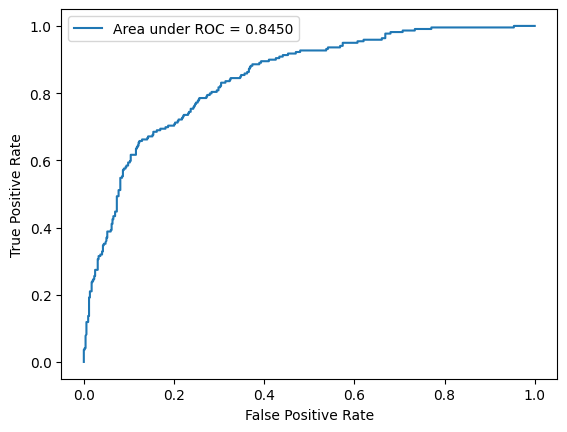

In [46]:
# plot the roc curve
fpr, tpr, _ = roc_curve(y_label, y_score)
plt.plot(fpr, tpr, label = "Area under ROC = {:.4f}".format(roc_score))
plt.legend(loc = 'best')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

**ROC Curve Description**

* X축은 False Positive Rate (위양성률, 실제로는 비독성인데 독성이라고 예측한 비율), Y축은 True Positive Rate (민감도, 실제로 독성인 것을 독성이라고 예측한 비율)을 나타낸다.
* 곡선이 왼쪽 상단에 가까울수록 모델이 좋다는 것을 의미한다.
* 여기서 ROC 곡선 아래 면적(AUC)이 0.8450이므로, 모델의 예측이 꽤 좋은 편임을 뜻한다.

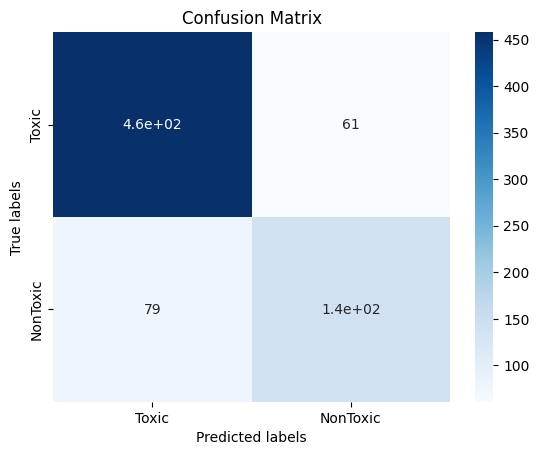

In [47]:
import seaborn as sns

conf_matrix = conf_matrix
ax= plt.subplot()
sns.heatmap(conf_matrix, annot=True, ax = ax, cmap = 'Blues'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['Toxic', 'NonToxic']); ax.yaxis.set_ticklabels(['Toxic', 'NonToxic']);

**Confusion Matrix Descriptin**

* 혼동 행렬은 모델의 예측 결과를 실제 값과 비교해서 보여주는 표이다.
* "Toxic"과 "NonToxic" 두 가지 클래스를 예측했다.
  * 왼쪽 위 (460): 실제로 독성인 데이터를 독성으로 맞게 예측한 경우 (True Positive).
  * 오른쪽 위 (61): 실제로 독성인 데이터를 비독성으로 잘못 예측한 경우 (False Negative).
  * 왼쪽 아래 (79): 실제로 비독성인 데이터를 독성으로 잘못 예측한 경우 (False Positive).*
  오른쪽 아래 (140): 실제로 비독성인 데이터를 비독성으로 맞게 예측한 경우 (True Negative).
* 이 혼동 행렬을 보면, 모델이 독성 데이터를 비독성으로 잘못 예측하는 경우(61)보다 비독성 데이터를 독성으로 잘못 예측하는 경우(79)가 조금 더 많다. 하지만 전반적으로 모델이 대부분의 데이터를 잘 예측하고 있다.